In [1]:
%load_ext autoreload
%autoreload 2

In [101]:
import os
import matplotlib
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, dense_diff_pool
import torch_explain as te
from torch_explain.logic.nn import entropy
from torch_explain.logic.metrics import test_explanation, complexity

import numpy as np
import pandas as pd
from pytorch_lightning.utilities.seed import seed_everything
from scipy.spatial.distance import cdist
from sympy import to_dnf, lambdify
from sklearn.metrics.cluster import homogeneity_score, completeness_score

import clustering_utils
import data_utils
import lens_utils
import model_utils
import persistence_utils
import visualisation_utils

In [3]:
# constants
DATASET_NAME = "BA_Shapes"
MODEL_NAME = f"GCN for {DATASET_NAME}"
NUM_CLASSES = 4
K = 10

TRAIN_TEST_SPLIT = 0.8

NUM_HIDDEN_UNITS = 20
EPOCHS = 7000
LR = 0.001

RANDOM_STATE = 0

NUM_NODES_VIEW = 5
NUM_EXPANSIONS = 2

LAYER_NUM = 3
LAYER_KEY = "conv3"

visualisation_utils.set_rc_params()

In [175]:
class ConceptEmbeddings(torch.nn.Linear):
    def __init__(self, in_features: int, out_features: int, emb_size: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(ConceptEmbeddings, self).__init__(in_features, out_features, bias, device, dtype)
        self.weight = torch.nn.Parameter(torch.empty((out_features, in_features, emb_size), **factory_kwargs))
        if bias:
            self.bias = torch.nn.Parameter(torch.empty(out_features, emb_size, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        h = (input @ self.weight).permute(1, 0, 2) + self.bias
        return h.permute(0, 2, 1)
    

class EntropyLinear(nn.Module):
    """Applies a linear transformation to the incoming data: :math:`y = xA^T + b`
    """

    def __init__(self, in_features: int, out_features: int, n_classes: int, temperature: float = 0.6,
                 bias: bool = True, conceptizator: str = 'identity_bool') -> None:
        super(EntropyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.n_classes = n_classes
        self.temperature = temperature
        self.alpha = None
        self.weight = nn.Parameter(torch.Tensor(n_classes, out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(n_classes, 1, out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if len(x.shape) > 2:
            x = x.unsqueeze(0)
        # compute concept-awareness scores
        gamma = self.weight.norm(dim=1, p=1)
        self.alpha = torch.exp(gamma/self.temperature) / torch.sum(torch.exp(gamma/self.temperature), dim=1, keepdim=True)

        # weight the input concepts by awareness scores
        self.alpha_norm = self.alpha / self.alpha.max(dim=1)[0].unsqueeze(1)
        self.concept_mask = self.alpha_norm > 0.5
#         print(x.shape, self.alpha_norm.unsqueeze(1).shape)
        x = x.multiply(self.alpha_norm.unsqueeze(1).unsqueeze(1))
#         print(x.shape)

        # compute linear map
#         print(x.shape, self.weight.permute(0, 2, 1).unsqueeze(1).shape)
        x = x.matmul(self.weight.permute(0, 2, 1).unsqueeze(1))# + self.bias
#         print(x.shape)
        return x.permute(1, 0, 2, 3).squeeze(-1)

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, n_classes={}'.format(
            self.in_features, self.out_features, self.n_classes
        )


# n_samples, gnn_emb_size, concept_emb_size, n_clustering = 10, 5, 3, 2
# gnn_embedding = torch.randn(n_samples, gnn_emb_size)
# ce_layer = ConceptEmbeddings(gnn_emb_size, n_clustering, concept_emb_size)
# lens = torch.nn.Sequential(EntropyLinear(n_clustering, 1, n_classes=4), nn.LeakyReLU(), torch.nn.Linear(concept_emb_size, 1))
# x = ce_layer(gnn_embedding)
# x = torch.softmax(x, dim=1)
# concepts = torch.div(x, torch.max(x, dim=1)[0].unsqueeze(1))
# y = lens(concepts)
# y.squeeze(-1)

In [176]:
# model definition
class GCN(nn.Module):
    def __init__(self, num_in_features, num_hidden_features, num_classes, n_clustering=3, concept_emb_size=10):
        super(GCN, self).__init__()
        
        self.conv0 = GCNConv(num_in_features, num_hidden_features)
        self.conv1 = GCNConv(num_hidden_features, num_hidden_features)
        self.conv2 = GCNConv(num_hidden_features, num_hidden_features)
        self.conv3 = GCNConv(num_hidden_features, num_hidden_features)
#         self.conv4 = GCNConv(num_hidden_features, num_hidden_features)
                
        # linear layers
        self.ce_layer = ConceptEmbeddings(num_hidden_features, n_clustering, concept_emb_size)
        self.lens = torch.nn.Sequential(EntropyLinear(n_clustering, 1, n_classes=num_classes),
                                        nn.LeakyReLU(), 
                                        torch.nn.Linear(concept_emb_size, 1))

    def forward(self, x, edge_index):
        x = self.conv0(x, edge_index)
        x = F.leaky_relu(x)

        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x)

        x = self.conv2(x, edge_index)
        x = F.leaky_relu(x)
        
        x = self.conv3(x, edge_index)
        x = F.leaky_relu(x)
        
#         x = self.conv4(x, edge_index)
#         x = F.leaky_relu(x)
                
        x = self.ce_layer(x)
        self.gnn_embedding = x
        
        x = F.softmax(x, dim=1)
        x = torch.div(x, torch.max(x, dim=1)[0].unsqueeze(1))
        concepts = x
        
        x = self.lens(x)
                
        return concepts, x.squeeze(-1)

In [196]:
def run_experiment(seed, path):
#     EPOCHS = 1
    config = {'seed': seed,
                       'dataset_name': DATASET_NAME,
                       'model_name': MODEL_NAME,
                       'num_classes': NUM_CLASSES,
                       'k': K,
                       'train_test_split': TRAIN_TEST_SPLIT,
                       'num_hidden_units': NUM_HIDDEN_UNITS,
                       'epochs': EPOCHS,
                       'lr': LR,
                       'num_nodes_view': NUM_NODES_VIEW,
                       'num_expansions': NUM_EXPANSIONS,
                       'layer_num': LAYER_NUM,
                       'layer_key': LAYER_KEY
                      }
        
    # load data
    G, labels = data_utils.load_syn_data(DATASET_NAME)
    data = data_utils.prepare_syn_data(G, labels, TRAIN_TEST_SPLIT)

    # model training
    model = GCN(data["x"].shape[1], NUM_HIDDEN_UNITS, NUM_CLASSES)
    
    # register hooks to track activation
    model = model_utils.register_hooks(model)
    
    # train 
    train_acc, test_acc, train_loss, test_loss = model_utils.train(model, data, EPOCHS, LR)
        
    visualisation_utils.plot_model_accuracy(train_acc, test_acc, MODEL_NAME, path)
    visualisation_utils.plot_model_loss(train_loss, test_loss, MODEL_NAME, path)
    
    x = data["x"]
    edges = data['edges'].long()
    edges_t = data['edge_list'].numpy()
    y = data["y"]
    train_mask = data["train_mask"]
    test_mask = data["test_mask"]
    
    # get model activations for complete dataset
    concepts, _ = model(x, edges)
#     activation = torch.squeeze(model_utils.activation_list[LAYER_KEY]).detach().numpy()
    activation = model.gnn_embedding.detach().numpy()
    
    # generate explanations
    explanations = lens_utils.explain_classes(model, concepts, y, train_mask, test_mask)
    
    for i in range(concepts.shape[2]):
        # find centroids
        print(activation[:, :, i].shape)
        print(concepts[:, :, i].shape)
        centroids, centroid_labels, used_centroid_labels = clustering_utils.find_centroids(activation[:, :, i], 
                                                                                           concepts[:, :, i], y)
        print(f"Number of cenroids: {len(centroids)}")

        # plot concept heatmaps
        visualisation_utils.plot_concept_heatmap(centroids, concepts[:, :, i], y, used_centroid_labels, 
                                                 MODEL_NAME, LAYER_NUM, path)

#         # concept alignment
#         homogeneity = homogeneity_score(y, used_centroid_labels)
#         # clustering efficency
#         completeness = completeness_score(y, used_centroid_labels)

#         print(f"Concept homogeneity score: {homogeneity}")
#         print(f"Concept completeness score: {completeness}")


#         # plot clustering
#         visualisation_utils.plot_clustering(seed, activation[:, :, i], y, centroids, centroid_labels, used_centroid_labels, MODEL_NAME, LAYER_NUM, path)

#         # calculate cluster sizing
#         cluster_counts = visualisation_utils.print_cluster_counts(used_centroid_labels)

#         # plot samples
#         sample_graphs, sample_feat = visualisation_utils.plot_samples(None, activation[:, :, i], y, LAYER_NUM, len(centroids), f"Differential Clustering {i}", "Raw", NUM_NODES_VIEW, edges_t, NUM_EXPANSIONS, path, concepts=centroids)
    
#     # dump data
#     persistence_utils.persist_experiment(config, path, 'config.z')
#     persistence_utils.persist_experiment(data, path,'data.z')
    
#     persistence_utils.persist_model(model, path, 'model.z')
    
#     persistence_utils.persist_experiment(concepts, path, 'concepts.z')
#     persistence_utils.persist_experiment(model_utils.activation_list, path, 'activation_list.z')
#     persistence_utils.persist_experiment(centroids, path, 'centroids.z')
#     persistence_utils.persist_experiment(centroid_labels, path, 'centroid_labels.z')
#     persistence_utils.persist_experiment(used_centroid_labels, path, 'used_centroid_labels.z')
    
#     concept_metrics = [('homogeneity', homogeneity), ('completeness', completeness), ('cluster_count', cluster_counts)]
#     persistence_utils.persist_experiment(concept_metrics, path, 'concept_metrics.z')
#     persistence_utils.persist_experiment(explanations, path, 'explanations.z')
#     persistence_utils.persist_experiment(sample_graphs, path, 'sample_graphs.z')
#     persistence_utils.persist_experiment(sample_feat, path, 'sample_feat.z')
    
    # clean up
    plt.close()
    


Global seed set to 42



START EXPERIMENT-----------------------------------------

Task: Node Classification
Number of features:  700
Number of labels:  700
Number of classes:  700
Number of edges:  2


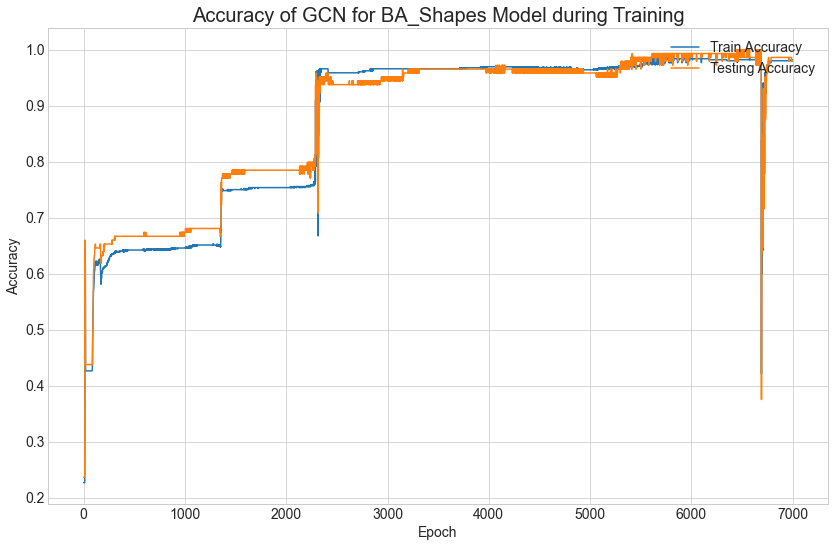

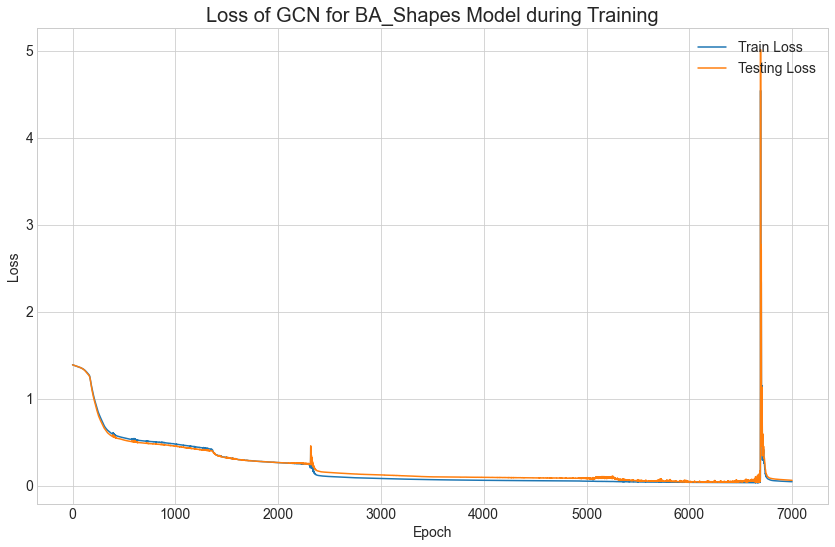

(700, 10)
torch.Size([700, 10])
Number of cenroids: 7
(700, 10)
torch.Size([700, 10])
Number of cenroids: 6
(700, 10)
torch.Size([700, 10])
Number of cenroids: 7
Explanation class 0: ~feature0000000000_0000000001 | (feature0000000000_0000000003 & ~feature0000000000_0000000006) - acc. = 0.9930 - compl. = 3.0000
Explanation class 1: feature0000000001_0000000007 & feature0000000001_0000000008 & ~feature0000000001_0000000006 - acc. = 0.4331 - compl. = 3.0000
Explanation class 2: feature0000000002_0000000007 | ~feature0000000002_0000000005 - acc. = 0.6080 - compl. = 2.0000
Explanation class 3: ~feature0000000000_0000000007 & ~feature0000000000_0000000009 - acc. = 0.5156 - compl. = 2.0000


ValueError: not enough values to unpack (expected 12, got 5)

<Figure size 1080x360 with 0 Axes>

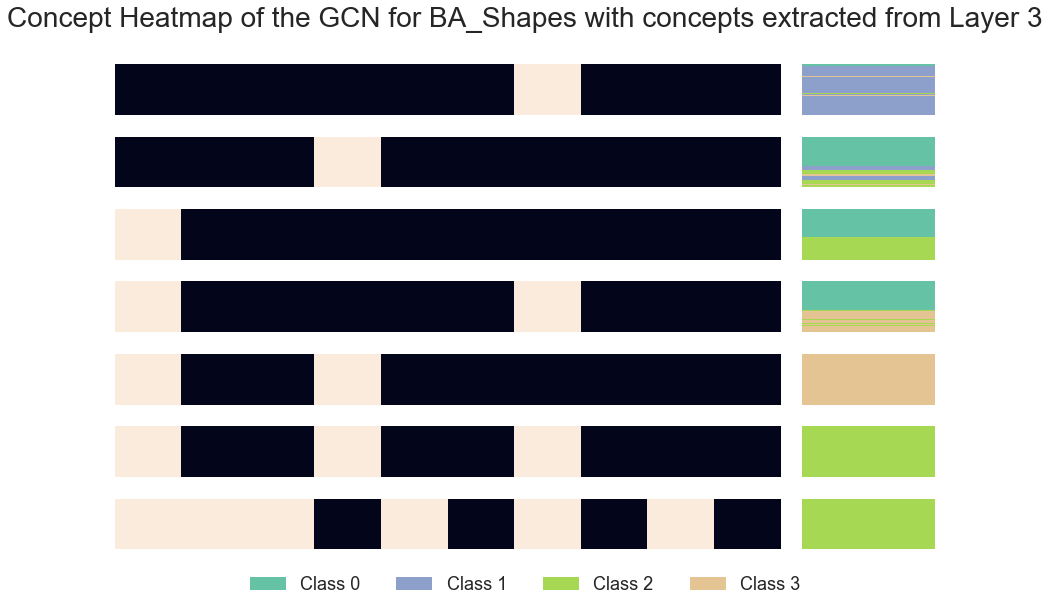

<Figure size 1080x360 with 0 Axes>

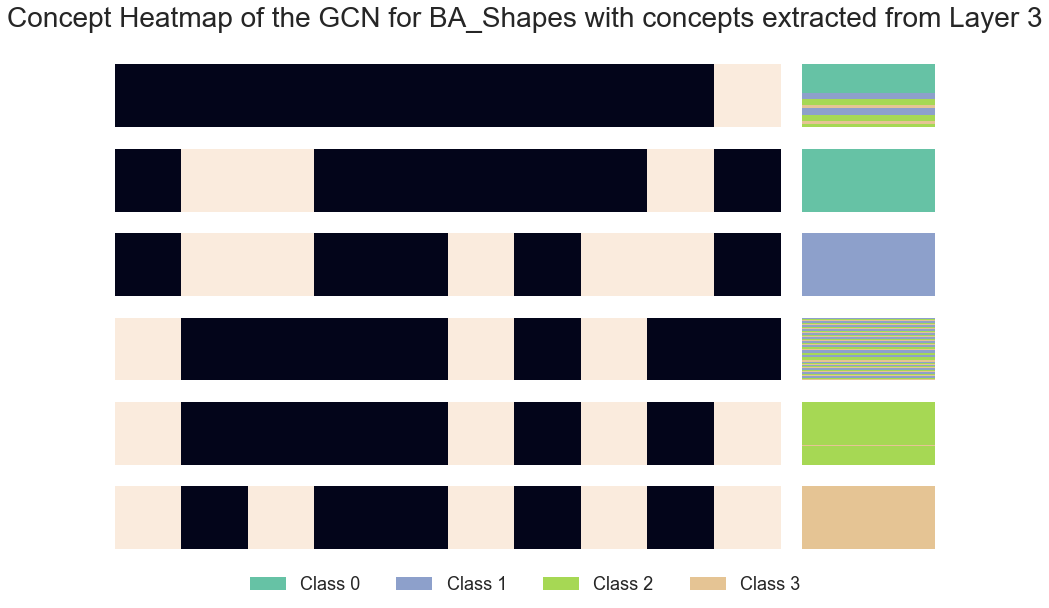

<Figure size 1080x360 with 0 Axes>

In [198]:
# run multiple times for confidence interval - seeds generated using Google's random number generator
random_seeds = [42, 19, 76, 58, 92]

for seed in random_seeds:
    print("\nSTART EXPERIMENT-----------------------------------------\n")
    seed_everything(seed)
    
    path = os.path.join("..", "output", DATASET_NAME, f"seed_{seed}")
    data_utils.create_path(path)

    run_experiment(seed, path)
    
    print("\nEND EXPERIMENT-------------------------------------------\n")
    
    break